![Plaatje](iris_tokio_drift.png)

Dit is een adaptatie van de bekende `iris` dataset waar drift in geïntroduceerd is. Dit is om te testen of onze ontworpen drift detectors ook daadwerkelijk drift kunnen detecteren.  
Hiervoor wordt voor een aantal scenarios synthetisch drift geïntroduceerd in de Iris dataset. 

## Mogelijke vormen van data drift

Aangezien de iris data beperkt is tot numerieke data, zijn er een aantal scenario's:

* Drift van de mean van een variabele
* Drift van de standaardafwijking van een variabele
* Drift van de verdeling van een variabele

In [1]:
from sklearn.datasets import load_iris
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
iris = load_iris(as_frame=True)
data = iris.frame
data['dataset_index'] = 0
data['drift_type'] = 'Geen (train data)'
data.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,dataset_index
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.0
mean,5.843333,3.057333,3.758000,1.199333,1.000000,0.0
std,0.828066,0.435866,1.765298,0.762238,0.819232,0.0
min,4.300000,2.000000,1.000000,0.100000,0.000000,0.0
25%,5.100000,2.800000,1.600000,0.300000,0.000000,0.0
50%,5.800000,3.000000,4.350000,1.300000,1.000000,0.0
75%,6.400000,3.300000,5.100000,1.800000,2.000000,0.0
max,7.900000,4.400000,6.900000,2.500000,2.000000,0.0


### Verdelingen  

De eerste stap is kijken naar de verdelingen in de originele `iris` dataset.

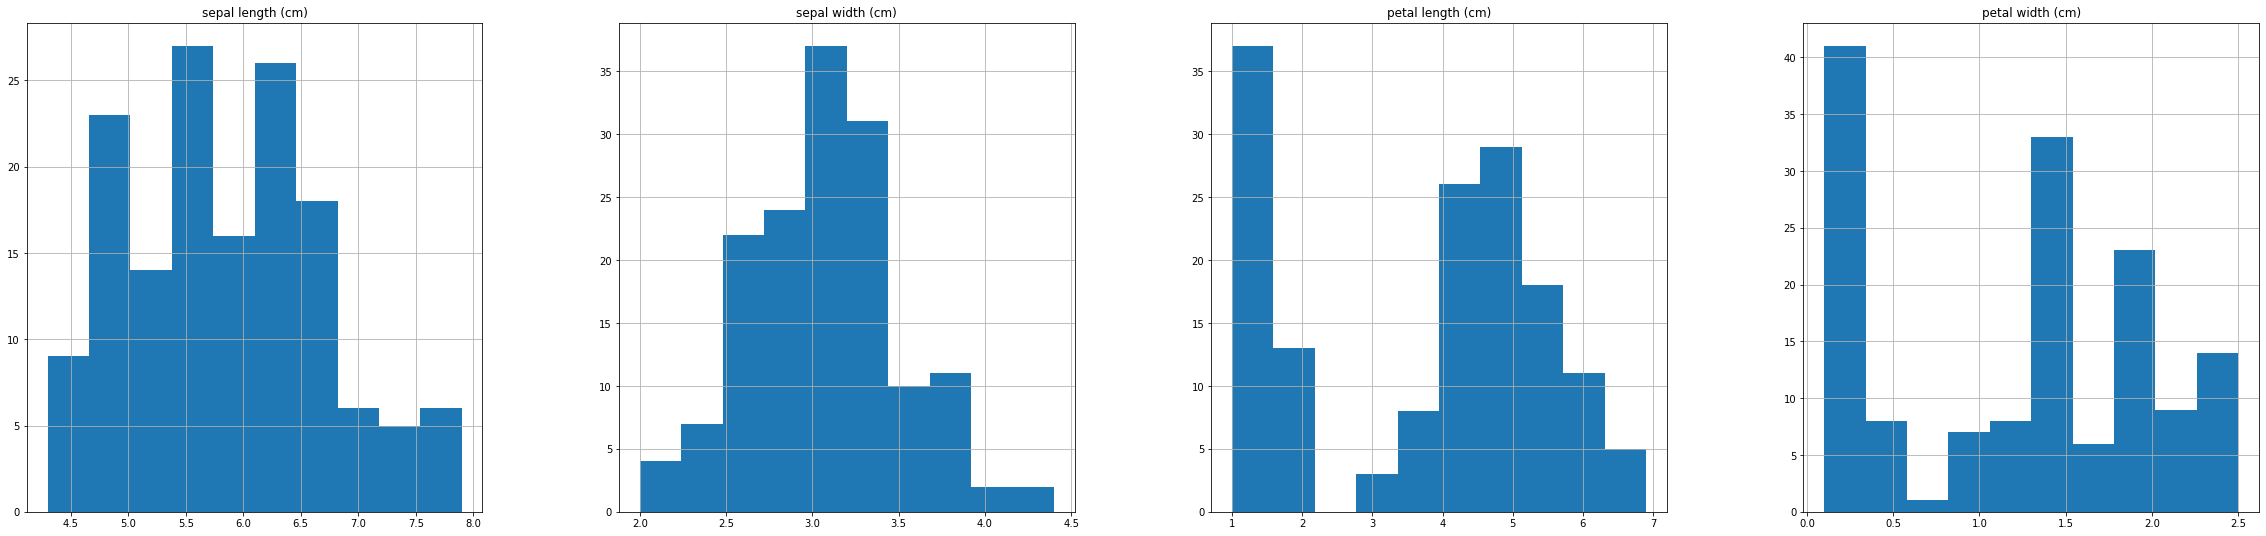

In [3]:
fig, axes = plt.subplots(1, 4, figsize=(40, 9))
[data.hist(column=col, ax=ax) for (col, ax) in zip(data.columns[:4], axes)];

Voor de eerste twee variabelen (`sepal length (cm)` en `sepal width (cm)`) is nog enigzins verdedigbaar te maken dat het om normaal verdeelde data gaat.  
Voor de andere twee variabelen (`petal length (cm)` en `petal width (cm)`) is dat veel moeilijker.
Qua verdelingen lijkt het dus logisch om voor de eerste twee uit een niet-normaal verdeelde verdeling te samplen. Voor de tweede set is het waarschijnlijk juist logischer om uit een normale verdeling te samplen.  
**Alternatief** is het ook waarden van variabelen om te wisselen, aangezien de verdelingen sterk van elkaar afwijken. Dit kost het minste tijd dus dat ga ik doen :) 

## Drift van mean en standaardafwijking

In [4]:
data_sum = data.copy().drop(['target', 'dataset_index'], axis=1)
data_sum = data_sum.agg(['mean', 'std'])
data_sum

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238


In [5]:
def drift_copy(index):
    """Maakt een kopie van de data en stelt een dataset_index in."""
    drift = data.copy()
    drift.dataset_index = index
    return drift

def drift_mean(index, factor, columns):
    """Maakt een drifted kopie aan van de data, waarbij het gemiddelde met factor keer de standaardafwijking is opgeschoven""" 
    drift = drift_copy(index)
    drift.drift_type = 'mean'
    for col in columns:
        drift[col] = drift[col] + factor * data_sum.loc['std', col]
    
    return drift

def drift_std(index, factor, columns):
    """Maakt een drifted kopie van de data, waar de spreiding om het gemiddelde wordt uitvergroot"""
    drift = drift_copy(index)
    drift.drift_type = 'std'
    for col in columns:
        mean = data_sum.loc['mean', col]  # mean uitlezen uit data_sum
        val = drift[col] - mean   # nulpunt naar mean verschuiven
        val = val * factor        # waarden met factor vergroten -> grotere afstand van gemiddelde
        val = val + mean          # mean weer toevoegen        
        drift[col] = val
    return drift

## Drift van verdelingen

Quick and dirty: door schuiven van kolomwaarden, dit is simpel te doen met `pd.DataFrame.rename()`.

In [6]:
class LoopIterator:
    """Object wat oneindig kan itereren over een set elementen
    Parameters:
        offset: hoeveel stappen al gemaakt moeten zijn voor het opleveren van de iterator.
    """
    def __init__(self, elements, offset: int=None):
        self.elements = elements
        self.iter = iter(self.elements)
        if offset is not None:
            self.shift(offset)
        
    def shift(self, offset):
        """Roept de iterator offset keer aan, om een shift te introduceren."""
        offset = offset % len(self.elements)   # zorgen dat niet nodeloos vaak door de lijst wordt geloopt     
        for n in range(offset):
            next(self.iter)
    
    def __next__(self):
        try:
            return next(self.iter)
        except StopIteration:  # reset the iterator if the iterator is exhausted
            self.iter = iter(self.elements)  
            return next(self.iter)   
        

def drift_wissel_verdeling(index, shift, columns):
    """Verwisselt kolommen met een aangegeven shift"""
    drift = drift_copy(index)
    drift.drift_type = 'verdeling'
    cols = columns
    iter_cols = LoopIterator(cols, shift)   # maakt een iterator over de kolommen, met een saangegeven shift
    colnames = {col: next(iter_cols) for col in cols}  # eerstvolgende kolom pakken met aangegeven shift
    drift = drift.rename(columns=colnames)
    
    return drift

In [7]:
index_offset = 1
mean_factors = np.arange(0, 5, 0.5)
std_factors = np.arange(1.5, 6.5, 0.5)
columns = data_sum.columns[:1]  # alleen eerste kolom driften voor mean en std

m_drift = [drift_mean(i + index_offset, factor, columns) for (i, factor) in enumerate(mean_factors)]
index_offset = index_offset + len(mean_factors)
s_drift= [drift_std(i + index_offset, factor, columns) for (i, factor) in enumerate(std_factors)]
index_offset = index_offset + len(std_factors)
v_drift = [drift_wissel_verdeling(i + index_offset-1, i, data_sum.columns) for i in range(1, len(data_sum.columns))]

drift_data = pd.concat([data] + m_drift + s_drift + v_drift)


In [8]:
drift_data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,dataset_index,drift_type
0,5.1,3.5,1.4,0.2,0,0,Geen (train data)
1,4.9,3.0,1.4,0.2,0,0,Geen (train data)
2,4.7,3.2,1.3,0.2,0,0,Geen (train data)
3,4.6,3.1,1.5,0.2,0,0,Geen (train data)
4,5.0,3.6,1.4,0.2,0,0,Geen (train data)
...,...,...,...,...,...,...,...
145,3.0,5.2,2.3,6.7,2,23,verdeling
146,2.5,5.0,1.9,6.3,2,23,verdeling
147,3.0,5.2,2.0,6.5,2,23,verdeling
148,3.4,5.4,2.3,6.2,2,23,verdeling


## Opslaan voor DriftDataset

Om de hele pipeline van het dashboard te kunnen testen ga ik dit opslaan in .csv bestanden per dataset_index. 

In [9]:
def save_iris_drift(drift: pd.DataFrame, datum: str='1900-01-01', path: Path=Path('iris_drift_data')):
    datum = pd.to_datetime(datum)    # basis datum aanmaken
    drift = drift.copy()
    
    if not path.exists():
        path.mkdir(parents=True)
    
    for index in drift.dataset_index.unique():
        data = drift[drift.dataset_index == index].drop('dataset_index', axis=1)  # filteren op dataset_index en deze kolom verwijderen

        offset = pd.DateOffset(months=index)  # maand later obv index
        file_datum = (datum + offset).strftime('%Y-%m-%d')   # datum uitrekenen en naar juiste format
                
        filename = f'iris_data_{file_datum}.csv'
        print(f'saving {filename}')
        data.to_csv(path/filename, index=False)
        
save_iris_drift(drift_data)

saving iris_data_1900-01-01.csv
saving iris_data_1900-02-01.csv
saving iris_data_1900-03-01.csv
saving iris_data_1900-04-01.csv
saving iris_data_1900-05-01.csv
saving iris_data_1900-06-01.csv
saving iris_data_1900-07-01.csv
saving iris_data_1900-08-01.csv
saving iris_data_1900-09-01.csv
saving iris_data_1900-10-01.csv
saving iris_data_1900-11-01.csv
saving iris_data_1900-12-01.csv
saving iris_data_1901-01-01.csv
saving iris_data_1901-02-01.csv
saving iris_data_1901-03-01.csv
saving iris_data_1901-04-01.csv
saving iris_data_1901-05-01.csv
saving iris_data_1901-06-01.csv
saving iris_data_1901-07-01.csv
saving iris_data_1901-08-01.csv
saving iris_data_1901-09-01.csv
saving iris_data_1901-10-01.csv
saving iris_data_1901-11-01.csv
saving iris_data_1901-12-01.csv
